using:
- subject-wise normalization
- segment length of 200

In [1]:
import tensorflow as tf
from tensorflow.keras import models, Model
from tensorflow.keras.applications import MobileNetV2, VGG16
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPool2D, BatchNormalization, Dropout, Input, Concatenate, GlobalAvgPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt
import os
import json

In [2]:
def evaluator(y_pred, y_true, verbose=False):
    """Returns evaluation metric scores"""
    accuracy = accuracy_score(y_pred=y_pred, y_true=y_true)
    balanced_accuracy = balanced_accuracy_score(y_pred=y_pred, y_true=y_true)
    f1 = f1_score(y_pred=y_pred, y_true=y_true, average='weighted')
    recall = recall_score(y_pred=y_pred, y_true=y_true, average='weighted')
    precision = precision_score(y_pred=y_pred, y_true=y_true, average='weighted')
    confusion = confusion_matrix(y_pred=y_pred, y_true=y_true)

    # display scores
    if verbose:
        ConfusionMatrixDisplay(confusion_matrix=confusion, display_labels=[False, True]).plot(cmap=plt.cm.Blues)
        plt.title('Physical fatigue')

        print(f'accuracy: {accuracy}\n'
              f'balanced accuracy: {balanced_accuracy}\n'
              f'f1 (weighted): {f1}\n'
              f'recall (weighted): {recall}\n'
              f'precision (weighted): {precision}')

    return {'accuracy': accuracy,
            'balanced_accuracy': balanced_accuracy,
            'f1': f1,
            'recall': recall,
            'precision': precision}

def test_set_evaluator(model, path, test_indices):
    # load + predict test data
    y_true = np.empty(len(test_indices), dtype=int)
    y_pred = np.empty(len(test_indices), dtype=float)

    for i, index in enumerate(test_indices):
        X_i = np.load(path + f'/feature_vector{index}.npy', allow_pickle=True)
        y_true_i = np.load(path + f'/labels{index}.npy', allow_pickle=True)[variable]

        X_i = tf.expand_dims(X_i, axis=0) # add "batch dimension"
        logits_pred_i = model.predict(X_i)

        y_true[i] = y_true_i
        y_pred[i] = logits_pred_i

    y_probs = tf.math.sigmoid(y_pred)
    y_pred = tf.round(y_probs)

    # print metrics
    evaluator(y_pred, y_true, verbose=True)

    # plot distribution of predictions
    plt.subplots_adjust(left=0.1,
                        bottom=0.01,
                        right=1.2,
                        top=0.6,
                        wspace=0.4,
                        hspace=0.4)

    # predicted probabilities
    plt.subplot(1, 2, 1)
    plt.hist(y_probs)
    plt.title('P(y == 1)')
    plt.vlines(x=0.5, ymin=0, ymax=len(y_probs), color='red')

    # predicted labels
    plt.subplot(1, 2, 2)
    plt.hist(y_pred)
    plt.title('Labels')

    plt.show()

In [3]:
VARIABLES = ['ActivityCounts', 'Barometer', 'BloodPerfusion',
             'BloodPulseWave', 'EnergyExpenditure', 'HR',
             'HRV', 'RESP', 'Steps', 'SkinTemperature']

In [4]:
GRAYSCALE = False # grayscale or rgb

# Import data

In [5]:
variable = {'phF': 0, 'MF': 1}['phF'] # TODO: for now just classify one variable

In [6]:
path = './Output'

In [7]:
# dimensions
N, HEIGHT, WIDTH, CHANNELS = sum([1 for p in os.listdir(path) if (p[:14] == 'feature_vector' and p[:19] != 'feature_vector_stat')]), \
                             *np.load(path + '/feature_vector0.npy').shape
CHANNELS = len(VARIABLES) if GRAYSCALE else CHANNELS # reduce channels for grayscale

# metadata (subjectID etc.)
with open(path + '/metadata.txt') as f:
    metadata = f.read()
metadata = json.loads(metadata.replace('\'', '\"').replace('False', 'false').replace('True', 'true')) # doesn't accept other chars

In [8]:
print(f'Total datapoints: {N}')

Total datapoints: 1218


# Train/validation split

In [9]:
VALIDATION_SIZE = 0.2

In [10]:
# use unaugmented data for validation set
non_augmented = [i for i, meta in enumerate(metadata) if meta['augmented'] == False]

validation_indices = np.random.choice(non_augmented, int(N * VALIDATION_SIZE), replace=False)
training_indices = np.delete(np.arange(N), validation_indices)

In [11]:
print(f'Training set: {len(training_indices)}')
print(f'Validation set: {len(validation_indices)}')

Training set: 975
Validation set: 243


# Define data generator

In [12]:
# image-wise
def rgb2gray(rgb):
    """greyscale = 0.2989 * red + 0.5870 * green + 0.1140 * blue"""
    return np.dot(rgb[:, :, :3], [0.2989, 0.5870, 0.1140])

In [13]:
class DataGenerator(Sequence):

    def __init__(self, data_path: str, indices_dataset: list, batch_size=32, dim=(HEIGHT, WIDTH), n_channels=CHANNELS, shuffle=True):
        self.data_path = data_path # path to full dataset
        self.dim = dim # image dimension
        self.batch_size = batch_size
        self.indices_dataset = indices_dataset # indices of full dataset (different for train/validation/test set)
        self.n_channels = n_channels
        self.shuffle = shuffle

        self.on_epoch_end() # shuffle data for each epoch

    def on_epoch_end(self):
        """
        Shuffle data for each epoch
        """
        if self.shuffle:
            np.random.shuffle(self.indices_dataset)

    def __data_generation(self, indices):
        """
        Loads and returns datapoints[indices]
        """
        # init
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty(self.batch_size, dtype=float) # TODO: int for non-logits

        # load individual datapoints
        for i, index in enumerate(indices):
            images = np.load(self.data_path + f'/feature_vector{index}.npy', allow_pickle=True)
            if GRAYSCALE:
                images_gray = np.empty((HEIGHT, WIDTH, self.n_channels))
                for j in range(len(VARIABLES)):
                    image_rgb = images[:, :, (3 * j): (3 * (j + 1))]
                    image_gray = rgb2gray(image_rgb)
                    images_gray[:, :, j] = image_gray
                images = images_gray

            X[i, ] = images
            y[i] = np.load(self.data_path + f'/labels{index}.npy', allow_pickle=True)[variable] # TODO: for now just one variable

        return X, y

    def __len__(self):
        """
        Number of batches per epoch
        """
        return int(np.floor(len(self.indices_dataset) / self.batch_size))

    def __getitem__(self, index):
        """
        Generates batch[index]
        """
        # calculate indices of batch
        indices = self.indices_dataset[index * self.batch_size:(index + 1) * self.batch_size]

        # generate batch
        X, y = self.__data_generation(indices)

        return X, y

# Upsampling

In [14]:
UPSAMPLING_STRATEGY = 'nothing' # ['repeat', 'nothing']

In [15]:
def check_imbalance(path_to_labels, indices):
    """Returns indices of positives/negatives"""
    y = np.empty((len(indices), 2), dtype=int)
    for i, index in enumerate(indices):
        y[i, ] = np.load(path_to_labels + f'/labels{index}.npy', allow_pickle=True)

    positives = np.where(y[:, variable] == 1)[0] # TODO: for now just one variable
    negatives = np.where(y[:, variable] == 0)[0] # TODO: for now just one variable

    return np.array(indices)[positives], np.array(indices)[negatives]


# validation set
positives, negatives = check_imbalance(path, validation_indices)
print(f'validation: (+: {len(positives)}, -: {len(negatives)})')

# training set
positives, negatives = check_imbalance(path, training_indices)
print(f'train_set: (+: {len(positives)}, -: {len(negatives)})')

sample_weight = len(negatives) / len(positives) # for weighted cross-entropy

# upsampling training set
if UPSAMPLING_STRATEGY == 'repeat':
    upsampled_indices = np.random.choice(negatives, size=(len(positives) - len(negatives)), replace=True) # with replacement
    upsampled_indices = np.append(upsampled_indices, np.arange(N))
    training_indices = np.append(positives, negatives) # update

    positives, negatives = check_imbalance(path, upsampled_indices)
    print(f'train_set (upsampled): (+: {len(positives)}, -: {len(negatives)})')
if UPSAMPLING_STRATEGY == 'nothing':
    pass

print(f'\nWeighted loss function: weight = {sample_weight}')

validation: (+: 182, -: 61)
train_set: (+: 735, -: 240)

Weighted loss function: weight = 0.32653061224489793


# CNN

Data generators

In [16]:
training_batch_generator = DataGenerator(data_path=path, indices_dataset=training_indices, batch_size=16)
validation_batch_generator = DataGenerator(data_path=path, indices_dataset=validation_indices, batch_size=16)

Model

In [17]:
# additional functions
# loss function
def weighted_cross_entropy(weight):
    def weighted_cross_entropy_with_logits(labels, logits):
        loss = tf.nn.weighted_cross_entropy_with_logits(
            labels, logits, weight
        )
        return loss
    return weighted_cross_entropy_with_logits

# F1-score, recall, precision (all weighted)
'''class ExtraMetrics(Callback):
    def __init__(self, path, indices, batch_size):
        super().__init__()

        self.batch_size = batch_size
        self.dataset_size = len(indices)
        self.data_generator = DataGenerator(data_path=path, indices_dataset=indices, batch_size=batch_size)

        self.val_precisions = None
        self.val_recalls = None
        self.val_f1s = None

    def on_train_begin(self, logs={}):
        self.val_f1s = []
        self.val_recalls = []
        self.val_precisions = []

    def on_epoch_end(self, epoch, logs={}):
        # load datapoints
        y_true = np.empty(self.dataset_size, dtype=int)
        y_pred = np.empty(self.dataset_size, dtype=int)
        for batch_index in range(len(self.data_generator)):
            X_batch, y_true_batch = self.data_generator.__getitem__(batch_index)
            logits_pred_batch = self.model.predict(X_batch)
            y_pred_batch = (np.asarray(tf.math.sigmoid(logits_pred_batch))).round()

            y_true[batch_index * self.batch_size:(batch_index + 1) * self.batch_size] = y_true_batch.ravel()
            y_pred[batch_index * self.batch_size:(batch_index + 1) * self.batch_size] = y_pred_batch.ravel()

        f1 = f1_score(y_pred, y_true, average='weighted')
        recall = recall_score(y_pred, y_true, average='weighted')
        precision = precision_score(y_pred, y_true, average='weighted')

        self.val_f1s.append(f1)
        self.val_recalls.append(recall)
        self.val_precisions.append(precision)

        print(f' - val_f1: {f1} - val_precision: {recall} - val_recall: {precision}')'''

class ExtraMetrics(Callback):
    def __init__(self, path, indices):
        super().__init__()

        self.path = path
        self.indices = indices

        self.val_precisions = None
        self.val_recalls = None
        self.val_f1s = None

    def on_train_begin(self, logs={}):
        self.val_f1s = []
        self.val_recalls = []
        self.val_precisions = []

    def on_epoch_end(self, epoch, logs={}):
        # load datapoints
        y_true = np.empty(len(self.indices), dtype=int)
        y_pred = np.empty(len(self.indices), dtype=float)

        for i, index in enumerate(self.indices):
            X_i = np.load(self.path + f'/feature_vector{index}.npy', allow_pickle=True)
            y_true_i = np.load(self.path + f'/labels{index}.npy', allow_pickle=True)[variable]

            X_i = tf.expand_dims(X_i, axis=0) # add "batch dimension"
            logits_pred_i = model.predict(X_i)

            y_true[i] = y_true_i
            y_pred[i] = logits_pred_i

        y_probs = tf.math.sigmoid(y_pred)
        y_pred = tf.round(y_probs)

        f1 = f1_score(y_pred=y_pred, y_true=y_true, average='weighted')
        recall = recall_score(y_pred=y_pred, y_true=y_true, average='weighted')
        precision = precision_score(y_pred=y_pred, y_true=y_true, average='weighted')

        self.val_f1s.append(f1)
        self.val_recalls.append(recall)
        self.val_precisions.append(precision)

        print(f' - val_f1: {f1} - val_precision: {recall} - val_recall: {precision}')

In [18]:
# TODO: make possible for grayscale
class CNN(tf.keras.Model):

    def __init__(self, name='custom_CNN', **kwargs):
        super(CNN, self).__init__(name, **kwargs)

        self.in_shape = (HEIGHT, WIDTH, CHANNELS)
        self.in_shape_mobilenet = (HEIGHT, WIDTH, 3)

        # MobileNetV2 embedding
        self.mobilenet = VGG16(input_shape=self.in_shape_mobilenet, weights='imagenet', include_top=False)
        self.mobilenet._name = 'vgg16'
        self.mobilenet.trainable = False
        self.finetuning = False
        self.out_shape_mobilenet = self.mobilenet.layers[-1].output_shape # for one spectrogram

        # Concatenation
        self.concat = Concatenate(name='concat')

        # Global pooling
        self.pool = GlobalAvgPool2D(name='global_avg_pool')

        # TODO: more sophisticated dense (dropout, regularizer, init., ...)
        # Fully-connected network
        self.flatten = Flatten(name='flatten', input_shape=(self.out_shape_mobilenet * (CHANNELS // 3), ))
        self.dense = Dense(1, name='dense') # keep logits
        self.out_shape = 1

        # build graph
        self.build_graph()

    def build_graph(self):
        self.build(input_shape=(None, *self.in_shape))
        x = Input(shape=self.in_shape)
        Model(inputs=[x], outputs=self.call(x))

    def set_finetuning(self, mode=True):
        self.finetuning = mode
        self.mobilenet.trainable = mode

        for layers in self.mobilenet.layers:
            layers.trainable = False

        # "activate" last conv layer of MobileNet
        self.mobilenet.layers[-3].trainable = mode
        self.mobilenet.layers[-2].trainable = mode

    def call(self, inputs):
        """
        Model predictions (logits)
        :param inputs: all spectrograms of shape (HEIGHT, WIDTH, CHANNELS)
        :return: class prediction (logits)
        """
        # MobileNetV2 embeddings
        x = [self.mobilenet(inputs[..., i:i+3], training=self.finetuning) for i in range(0, CHANNELS, 3)]

        # Concatenation
        x = self.concat(x)

        # Global pooling
        x = self.pool(x)

        # Fully-connected network
        x = self.flatten(x)
        x = self.dense(x)

        return x

# Simple train/test split

Training

In [19]:
model = CNN()

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss=weighted_cross_entropy(sample_weight))

model.summary()

Model: "cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 11, 6, 512)        14714688  
_________________________________________________________________
concat (Concatenate)         (None, 11, 6, 5120)       0         
_________________________________________________________________
global_avg_pool (GlobalAvera (None, 5120)              0         
_________________________________________________________________
flatten (Flatten)            (None, 5120)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 5121      
Total params: 14,719,809
Trainable params: 5,121
Non-trainable params: 14,714,688
_________________________________________________________________


In [20]:
%%time
extra_metrics = ExtraMetrics(path, validation_indices)
history = model.fit_generator(generator=training_batch_generator,
                              validation_data=validation_batch_generator,
                              epochs=10,
                              callbacks=[extra_metrics])

C:\Users\jjung\anaconda3\envs\tf-sklearn-keras\lib\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
60/60 [==============================] - 105s 1s/step - loss: 0.3454 - val_loss: 0.3426
 - val_f1: 0.6137003356770989 - val_precision: 0.6460905349794238 - val_recall: 0.5897105303793546
Epoch 2/10
60/60 [==============================] - 70s 1s/step - loss: 0.3403 - val_loss: 0.3422
 - val_f1: 0.5794551248380433 - val_precision: 0.5555555555555556 - val_recall: 0.6174892359102886
Epoch 3/10
60/60 [==============================] - 70s 1s/step - loss: 0.3392 - val_loss: 0.3437
 - val_f1: 0.4172548162715321 - val_precision: 0.3991769547325103 - val_recall: 0.6081805711435341
Epoch 4/10
60/60 [==============================] - 71s 1s/step - loss: 0.3414 - val_loss: 0.3468
 - val_f1: 0.6528761542431245 - val_precision: 0.7325102880658436 - val_recall: 0.6378406541973544
Epoch 5/10
60/60 [==============================] - 70s 1s/step - loss: 0.3401 - val_loss: 0.3443
 - val_f1: 0.6552616108171663 - val_precision: 0.7366255144032922 - val_recall: 0.6470050297210791
Epoch 6/10
60/

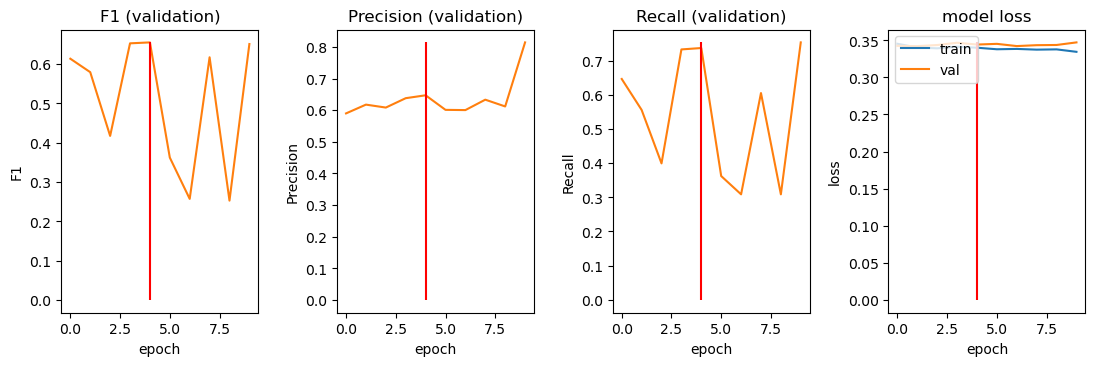

In [21]:
# plot training curve
plt.subplots_adjust(left=0.1,
                    bottom=0.01,
                    right=1.7,
                    top=0.6,
                    wspace=0.4,
                    hspace=0.4)

# mark best performing epoch
best_model_epoch = np.argmax(extra_metrics.val_f1s)

# metric 1
plt.subplot(1, 4, 1)
plt.plot(extra_metrics.val_f1s, color='C1')
plt.vlines(x=best_model_epoch, ymin=0, ymax=max(extra_metrics.val_f1s), color='red')
plt.title('F1 (validation)')
plt.ylabel('F1')
plt.xlabel('epoch')

# metric 2
plt.subplot(1, 4, 2)
plt.plot(extra_metrics.val_precisions, color='C1')
plt.vlines(x=best_model_epoch, ymin=0, ymax=max(extra_metrics.val_precisions), color='red')
plt.title('Precision (validation)')
plt.ylabel('Precision')
plt.xlabel('epoch')

# metric 3
plt.subplot(1, 4, 3)
plt.plot(extra_metrics.val_recalls, color='C1')
plt.vlines(x=best_model_epoch, ymin=0, ymax=max(extra_metrics.val_recalls), color='red')
plt.title('Recall (validation)')
plt.ylabel('Recall')
plt.xlabel('epoch')

# loss
plt.subplot(1, 4, 4)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.vlines(x=best_model_epoch, ymin=0, ymax=max(history.history['loss'] + history.history['val_loss']), color='red')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.show()

# Evaluation

accuracy: 0.7530864197530864
balanced accuracy: 0.5081967213114754
f1 (weighted): 0.6510824072195547
recall (weighted): 0.7530864197530864
precision (weighted): 0.8143046627895113


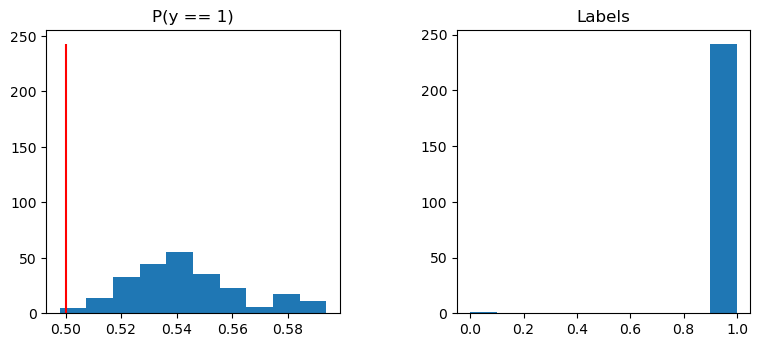

In [22]:
# latest model
test_set_evaluator(model, path, validation_indices)

In [ ]:
# best performing model
'''test_set_evaluator(CNN().load_weights(checkpoint_path_f1), validation_batch_generator)'''

# Finetuning

In [24]:
# activate finetuning
model.set_finetuning(mode=True)

In [26]:
# check it worked
model.compile(optimizer=Adam(learning_rate=1e-7),
              loss=weighted_cross_entropy(sample_weight))

model.summary()

Model: "cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet (Functional)       (None, 12, 4, 1280)       2257984   
_________________________________________________________________
concat (Concatenate)         (None, 12, 4, 12800)      0         
_________________________________________________________________
global_avg_pool (GlobalAvera (None, 12800)             0         
_________________________________________________________________
flatten (Flatten)            (None, 12800)             0         
_________________________________________________________________
dense (Dense)                (None, 1)                 12801     
Total params: 2,270,785
Trainable params: 424,961
Non-trainable params: 1,845,824
_________________________________________________________________


In [27]:
# train (finetuning)
history_finetuning = model.fit_generator(generator=training_batch_generator,
                                         validation_data=validation_batch_generator,
                                         epochs=5,
                                         callbacks=[extra_metrics])

C:\Users\jjung\anaconda3\envs\tf-sklearn-keras\lib\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
77/77 [==============================] - 70s 570ms/step - loss: 1.0818 - val_loss: 1.2482


C:\Users\jjung\anaconda3\envs\tf-sklearn-keras\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 - val_f1: 0.6357954885418536 - val_precision: 0.7447495961227787 - val_recall: 0.5546519609250419
Epoch 2/5
77/77 [==============================] - 42s 546ms/step - loss: 1.0587 - val_loss: 1.2156


C:\Users\jjung\anaconda3\envs\tf-sklearn-keras\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 - val_f1: 0.6357954885418536 - val_precision: 0.7447495961227787 - val_recall: 0.5546519609250419
Epoch 3/5
77/77 [==============================] - 42s 547ms/step - loss: 1.0538 - val_loss: 1.1916


C:\Users\jjung\anaconda3\envs\tf-sklearn-keras\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 - val_f1: 0.6357954885418536 - val_precision: 0.7447495961227787 - val_recall: 0.5546519609250419
Epoch 4/5
77/77 [==============================] - 37s 477ms/step - loss: 1.0429 - val_loss: 1.1876


C:\Users\jjung\anaconda3\envs\tf-sklearn-keras\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 - val_f1: 0.6357954885418536 - val_precision: 0.7447495961227787 - val_recall: 0.5546519609250419
Epoch 5/5
77/77 [==============================] - 38s 496ms/step - loss: 1.0372 - val_loss: 1.1914
 - val_f1: 0.6357954885418536 - val_precision: 0.7447495961227787 - val_recall: 0.5546519609250419


C:\Users\jjung\anaconda3\envs\tf-sklearn-keras\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


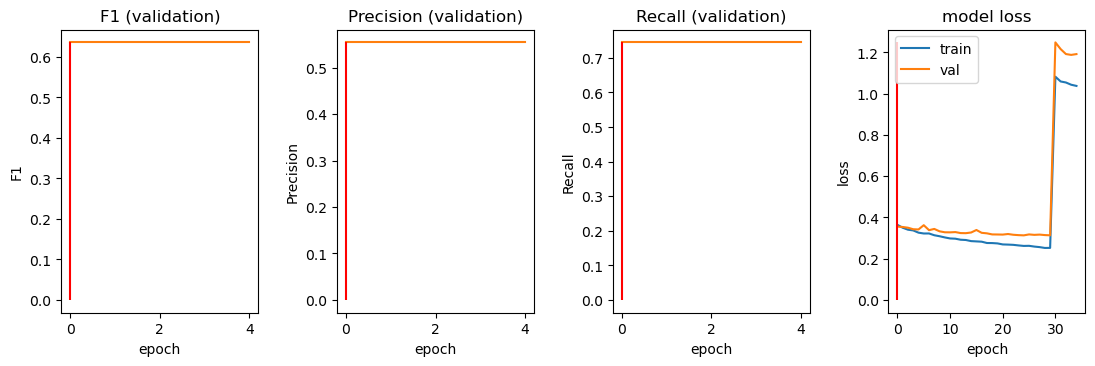

In [28]:
# concat information
full_history = {'loss': history.history['loss'] + history_finetuning.history['loss'],
                'val_loss': history.history['val_loss'] + history_finetuning.history['val_loss']}

# plot training curve
plt.subplots_adjust(left=0.1,
                    bottom=0.01,
                    right=1.7,
                    top=0.6,
                    wspace=0.4,
                    hspace=0.4)

# mark best performing epoch
best_model_epoch = np.argmax(extra_metrics.val_f1s)

# metric 1
plt.subplot(1, 4, 1)
plt.plot(extra_metrics.val_f1s, color='C1')
plt.vlines(x=best_model_epoch, ymin=0, ymax=max(extra_metrics.val_f1s), color='red')
plt.title('F1 (validation)')
plt.ylabel('F1')
plt.xlabel('epoch')

# metric 2
plt.subplot(1, 4, 2)
plt.plot(extra_metrics.val_precisions, color='C1')
plt.vlines(x=best_model_epoch, ymin=0, ymax=max(extra_metrics.val_precisions), color='red')
plt.title('Precision (validation)')
plt.ylabel('Precision')
plt.xlabel('epoch')

# metric 3
plt.subplot(1, 4, 3)
plt.plot(extra_metrics.val_recalls, color='C1')
plt.vlines(x=best_model_epoch, ymin=0, ymax=max(extra_metrics.val_recalls), color='red')
plt.title('Recall (validation)')
plt.ylabel('Recall')
plt.xlabel('epoch')

# loss
plt.subplot(1, 4, 4)
plt.plot(full_history['loss'])
plt.plot(full_history['val_loss'])
plt.vlines(x=best_model_epoch, ymin=0, ymax=max(full_history['loss'] + full_history['val_loss']), color='red')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.show()

C:\Users\jjung\anaconda3\envs\tf-sklearn-keras\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy: 0.7447495961227787
balanced accuracy: 0.5
f1 (weighted): 0.6357954885418536
recall (weighted): 0.7447495961227787
precision (weighted): 0.5546519609250419


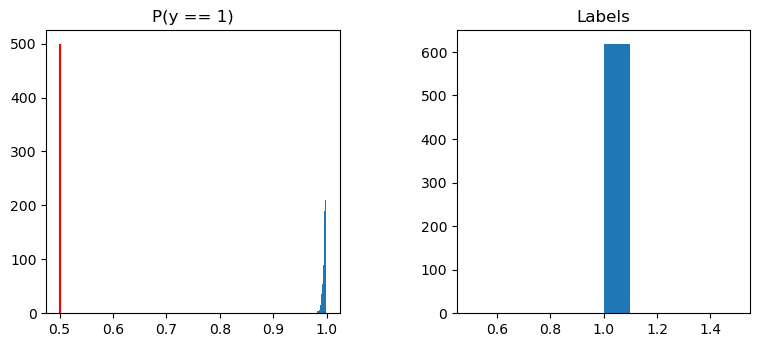

In [29]:
# evaluate
test_set_evaluator(model, path, validation_indices)

# Check same day segment prediction

In [23]:
X_dates = [meta['date'] for meta in metadata]

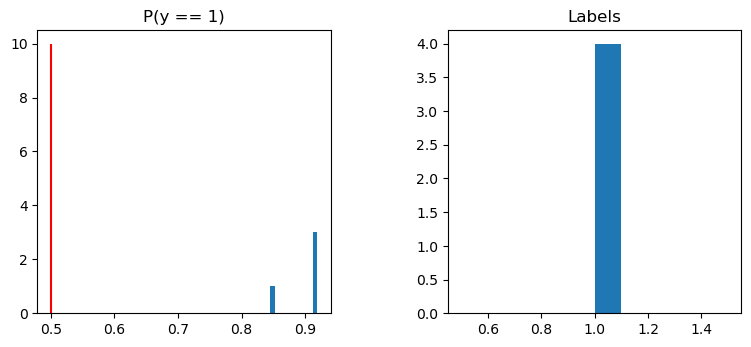

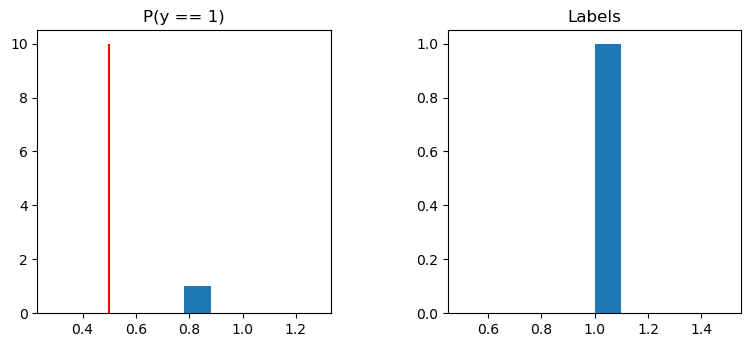

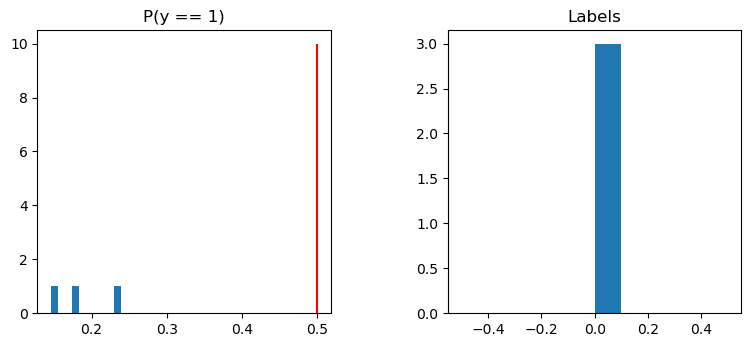

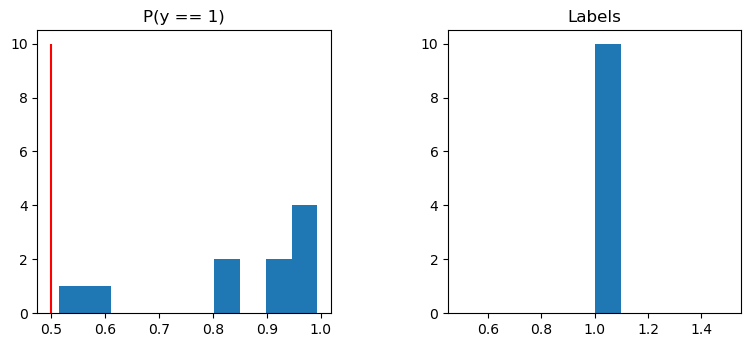

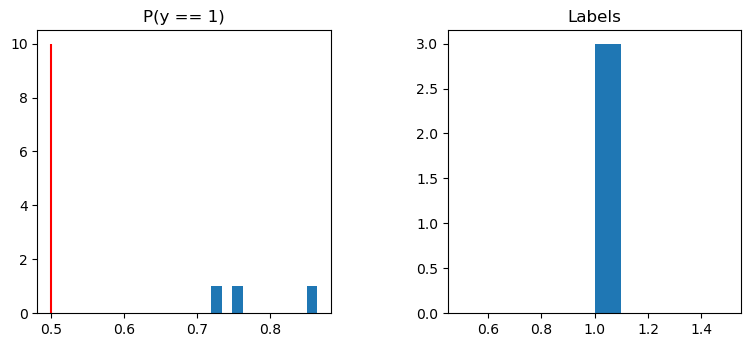

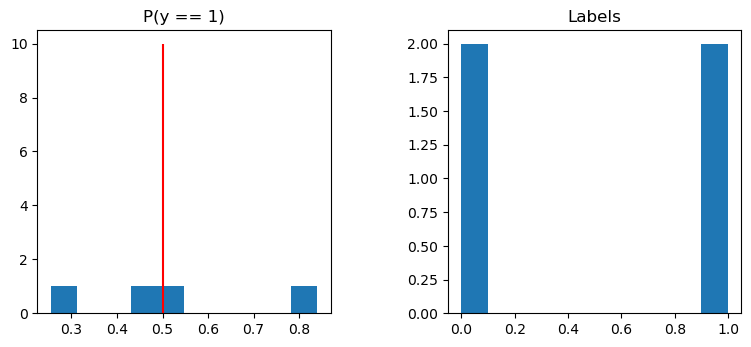

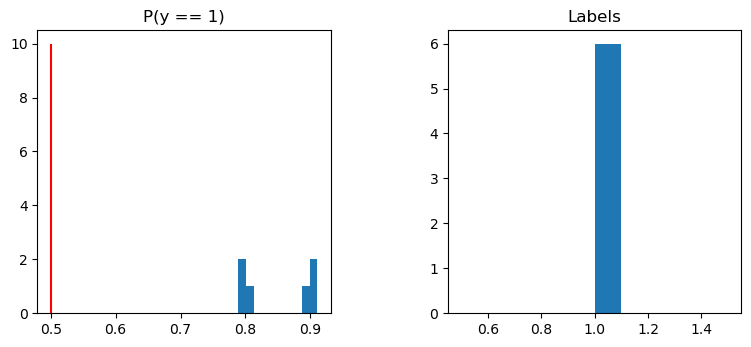

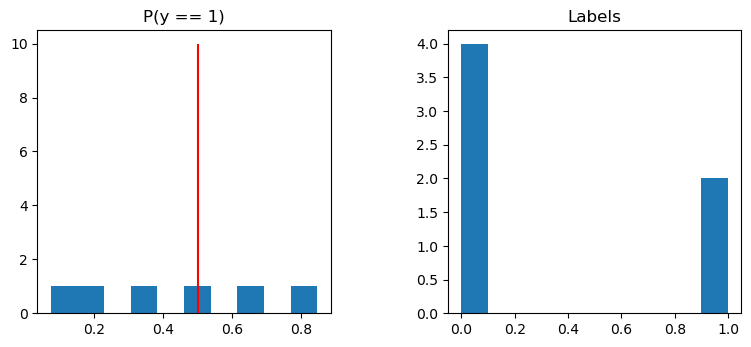

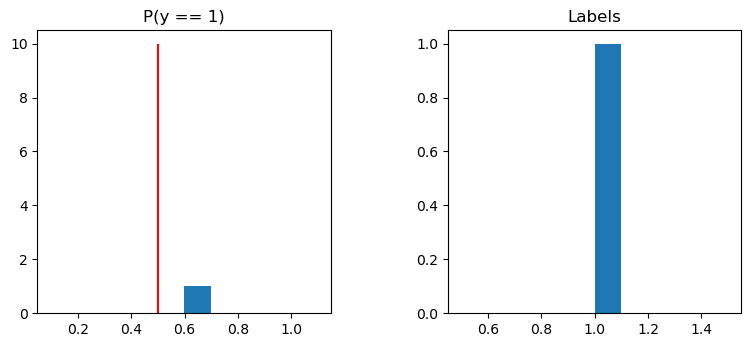

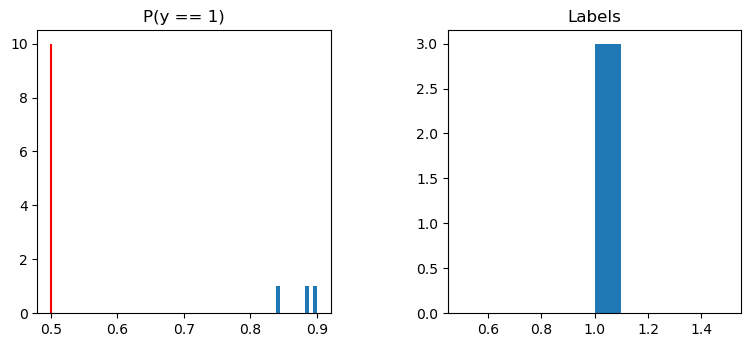

In [24]:
# analyze random day
for j in range(10):
    random_day = np.random.choice(np.unique(X_dates), 1)
    test_indices = [i for i in range(N) if X_dates[i] == random_day]

    # load datapoints
    y_true = np.empty(len(test_indices), dtype=int)
    y_pred = np.empty(len(test_indices), dtype=float)

    for i, index in enumerate(test_indices):
        X_i = np.load(path + f'/feature_vector{index}.npy', allow_pickle=True)
        y_true_i = np.load(path + f'/labels{index}.npy', allow_pickle=True)[variable]

        X_i = tf.expand_dims(X_i, axis=0) # add "batch dimension"
        logits_pred_i = model.predict(X_i)

        y_true[i] = y_true_i
        y_pred[i] = logits_pred_i

    y_probs = tf.math.sigmoid(y_pred)
    y_pred = tf.round(y_probs)

    # predict
    plt.subplots_adjust(left=0.1,
                        bottom=0.01,
                        right=1.2,
                        top=0.6,
                        wspace=0.4,
                        hspace=0.4)

    # predicted probabilities
    plt.subplot(1, 2, 1)
    plt.hist(y_probs)
    plt.title('P(y == 1)')
    plt.vlines(x=0.5, ymin=0, ymax=10, color='red')

    # predicted labels
    plt.subplot(1, 2, 2)
    plt.hist(y_pred)
    plt.title('Labels')

    plt.show()

# Save data

In [39]:
# save history
with open('./temp/history','w') as dat:
    dat.write(str(history.history))

In [76]:
# save model
model.save('./temp/model')

INFO:tensorflow:Assets written to: ./temp/checkpoint_latest\assets


C:\Users\jjung\anaconda3\envs\tf-sklearn-keras\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
